# Running CEDS Scenarios

In this notebook we document how to process and run data from the CEDS database.

In [1]:
%matplotlib inline

from os import listdir
from os.path import join, dirname
from pprint import pprint
from copy import deepcopy

import pandas as pd
import pyam
from pyam.utils import LONG_IDX
import pint
from pint.pandas_interface import PintArray
from pint.errors import DimensionalityError

import pymagicc
from pymagicc.io import MAGICCData

import matplotlib.pyplot as plt
plt.style.use('bmh') 

import expectexception

<IPython.core.display.Javascript object>


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
TEST_DATA_PATH = join("..", "tests", "test_data")

## Reading in a CEDS csv

To read in CEDS csv's, we make use of the `pyam` library which is specifically designed for this purpose.

In [4]:
def read_ceds_csv(file_to_read):
    return pyam.IamDataFrame(
        data=file_to_read,
        encoding="utf-8"
    )

ceds_pyam_df = read_ceds_csv(join(TEST_DATA_PATH, "ceds-format-example-2.csv"))
ceds_pyam_df  # this just shows the type of ceds_pyam_df
ceds_pyam_df.data.head()  # this returns the head of the underlying DataFrame

INFO:root:Reading `../tests/test_data/ceds-format-example-2.csv`


,model,scenario,region,variable,unit,year,value
0,foo,bar,R5ASIA,Emissions|BC,Mt BC/yr,2015,4.818396
91,foo,bar,R5LAM,Emissions|BC,Mt BC/yr,2015,0.969413
174,foo,bar,R5MAF,Emissions|BC,Mt BC/yr,2015,2.170508
257,foo,bar,R5OECD,Emissions|BC,Mt BC/yr,2015,0.818853
348,foo,bar,R5REF,Emissions|BC,Mt BC/yr,2015,0.459987


## Super brief intro to pyam

The `pyam` library provides some very natural ways of filtering their DataFrames. These are detailed in [their tutorial](https://github.com/IAMconsortium/pyam/blob/master/tutorial/pyam_first_steps.ipynb). Here we use them to help convert IAM data into the emissions variables, regions and units used by openscm and MAGICC.

In [5]:
# this only gets first level emissions and 
# World values
tdf = ceds_pyam_df.filter(
    level=1,
    region="World",
)
tdf.variables()
tdf.regions()
tdf.data.head()

0               Emissions|BC
1             Emissions|C2F6
2             Emissions|CCl4
3              Emissions|CF4
4           Emissions|CFC-11
5          Emissions|CFC-113
6          Emissions|CFC-114
7          Emissions|CFC-115
8           Emissions|CFC-12
9            Emissions|CH3Br
10         Emissions|CH3CCl3
11           Emissions|CH3Cl
12             Emissions|CH4
13              Emissions|CO
14             Emissions|CO2
15       Emissions|HCFC-141b
16       Emissions|HCFC-142b
17         Emissions|HCFC-22
18             Emissions|HFC
19         Emissions|HFC-125
20        Emissions|HFC-134a
21        Emissions|HFC-143a
22        Emissions|HFC-152a
23       Emissions|HFC-227ea
24          Emissions|HFC-23
25       Emissions|HFC-236fa
26       Emissions|HFC-245fa
27          Emissions|HFC-32
28      Emissions|HFC-365mfc
29    Emissions|HFC-43-10mee
30       Emissions|Halon1202
31       Emissions|Halon1211
32       Emissions|Halon1301
33       Emissions|Halon2402
34            

0    World
Name: region, dtype: object

,model,scenario,region,variable,unit,year,value
439,foo,bar,World,Emissions|BC,Mt BC/yr,2015,9.357836
1019,foo,bar,World,Emissions|BC,Mt BC/yr,2020,10.244688
1599,foo,bar,World,Emissions|BC,Mt BC/yr,2030,6.395458
2179,foo,bar,World,Emissions|BC,Mt BC/yr,2040,4.079147
2759,foo,bar,World,Emissions|BC,Mt BC/yr,2050,3.236156


## Checking an `IamDataFrame`

It is very easy to check that the sum of a given variable's sub-categories is equal to its declared total and that the sum of regions gives the world total.

We show how in the next cell.

In [6]:
# show check_internal_consistency method here once PR into pyam
# is accepted

## Converting CEDS data to openscm data

In the Python implementation of `openscm`, we want to work with `IamDataFrame`'s for as long as possible thanks to their useful aggregating, filtering and other methods. 

Hence all we do to convert from CEDS data to openscm is tweak the underlying `DataFrame`.

We start by aggregating the data from the CEDS csv into `openscm` relevant categories. 

We also strip 'equiv' and '-' from units so that pint can read the units and subsequently from variable names for consistency. Yes:

1. it looks odd to have HFC in units of 'CO2' but it's hopefully fairly clear that this is an equivalence unit
1. changing from IAM units and names in this way is annoying but pint is worth it so we make the switch

In [7]:
# before we do anything, we add a metadata attribute to pyam.IamDataFrame
# which we can use as a temporary measure in this notebook
pyam.IamDataFrame.metadata = dict()

def convert_pyam_df_to_openscm_df(pyam_df):
    TMP_INDEX = ['model', 'scenario', 'region', 'year', 'unit']
    
    ceds_openscm_var_mapping = {
        "Aircraft": ["Aircraft"],
        "International Shipping": ["International Shipping"],
        "AFOLULUC": ["Agricultural Waste Burning", "Agriculture", 
                     "Forest Burning", "Grassland Burning", 
                     "Peat Burning", "Aggregate - Agriculture and LUC"],
        "Fossil": ["Energy Sector", "Industrial Sector", 
                   "Residential Commercial Other", 
                   "Solvents Production and Application", 
                   "Transportation Sector", "Waste"]
    }
    
    openscm_df = pyam.IamDataFrame(data=pyam_df.data.copy())
    
    output_df = openscm_df.filter(level=1,).data
    sectoral_df = openscm_df.filter(
        level='1-', 
        keep=False
    )
    
    handled_vars = []
    metadata = {}
    var_dfs = []
    for variable in sectoral_df.variables():
        var_bits = variable.split("|")
        base_var = "|".join(var_bits[:2])
        extension = "|".join(var_bits[2:3])
        assert "|" not in extension, "Handling more than one level deep not ready yet"
        
        for category, suffixes in ceds_openscm_var_mapping.items():
            if extension not in suffixes:
                continue
                
            openscm_var = "{}|{}".format(
                "|".join(variable.split("|")[:-1]),
                category,
            )
            
            if openscm_var in handled_vars:
                continue
            handled_vars.append(openscm_var)
            
            contrib_vars = ["{}|{}".format(base_var, s) for s in suffixes]

            var_cat_df = sectoral_df.data[sectoral_df.data.variable.isin(contrib_vars)]
            var_cat_df = pd.DataFrame(var_cat_df.groupby(TMP_INDEX).sum()['value'])
            var_cat_df = pd.concat([var_cat_df], keys=[openscm_var], names=['variable'])
            
            var_dfs.append(var_cat_df.reset_index())

            metadata[openscm_var] = "Sum of {}".format(", ".join(contrib_vars))
    
    output_df = pd.concat([output_df] + var_dfs, sort=False)
    output_df.unit = output_df.unit.str.replace("-equiv", "").str.replace("-", "")
    output_df.variable = output_df.variable.str.replace("-", "")
    
    output_df = pyam.IamDataFrame(data=output_df)
    
    output_df.metadata = pyam_df.metadata
    output_df.metadata.update(metadata)
    
    return output_df

In [8]:
openscm_df = convert_pyam_df_to_openscm_df(ceds_pyam_df)

# check out metadata with this
print([
    "{}: {}".format(k,openscm_df.metadata[k])
    for k in list(openscm_df.metadata)[:3]
])

# check out table with this
openscm_df.head()

# check regions with this
openscm_df.regions()

# check out variables with this
openscm_df.variables()[:10]

# check out units with this
openscm_df.data.unit.unique()[:10]

['Emissions|BC|AFOLULUC: Sum of Emissions|BC|Agricultural Waste Burning, Emissions|BC|Agriculture, Emissions|BC|Forest Burning, Emissions|BC|Grassland Burning, Emissions|BC|Peat Burning, Emissions|BC|Aggregate - Agriculture and LUC', 'Emissions|BC|Aircraft: Sum of Emissions|BC|Aircraft', 'Emissions|BC|Fossil: Sum of Emissions|BC|Energy Sector, Emissions|BC|Industrial Sector, Emissions|BC|Residential Commercial Other, Emissions|BC|Solvents Production and Application, Emissions|BC|Transportation Sector, Emissions|BC|Waste']


,model,scenario,region,variable,unit,year,value
0,foo,bar,R5ASIA,Emissions|BC,Mt BC/yr,2015,4.818396
91,foo,bar,R5LAM,Emissions|BC,Mt BC/yr,2015,0.969413
174,foo,bar,R5MAF,Emissions|BC,Mt BC/yr,2015,2.170508
257,foo,bar,R5OECD,Emissions|BC,Mt BC/yr,2015,0.818853
348,foo,bar,R5REF,Emissions|BC,Mt BC/yr,2015,0.459987


0    R5ASIA
1     R5LAM
2     R5MAF
3    R5OECD
4     R5REF
5     World
Name: region, dtype: object

0                           Emissions|BC
1                  Emissions|BC|AFOLULUC
2                  Emissions|BC|Aircraft
3                    Emissions|BC|Fossil
4    Emissions|BC|International Shipping
5                         Emissions|C2F6
6                         Emissions|CCl4
7                          Emissions|CF4
8                        Emissions|CFC11
9                       Emissions|CFC113
Name: variable, dtype: object

array(['Mt BC/yr', 'kt C2F6/yr', 'kt CCl4/yr', 'kt CF4/yr', 'kt CFC11/yr',
       'kt CFC113/yr', 'kt CFC114/yr', 'kt CFC115/yr', 'kt CFC12/yr',
       'kt CH3Br/yr'], dtype=object)

## Converting units

In the next part we start to do unit conversions. Before moving on, we briefly explain how we do this.

We load units with Pint like so.

In [9]:
ureg = pint.UnitRegistry()  # start a unit repository using the default variables
ureg.load_definitions('emissions_units.txt')  # load emissions units too
ureg._contexts  # show us which contexts we have available

{'spectroscopy': <pint.context.Context at 0x10e6c4278>,
 'sp': <pint.context.Context at 0x10e6c4278>,
 'boltzmann': <pint.context.Context at 0x10e6c4198>,
 'chemistry': <pint.context.Context at 0x10e6c4550>,
 'chem': <pint.context.Context at 0x10e6c4550>,
 'AR4GWP12': <pint.context.Context at 0x10e70b240>}

In [10]:
# define some variables with units
a = 1*ureg.C
b = 1*ureg.CO2
c = 3*ureg.N2O

In [11]:
# they carry units with them
a
b
c

1 <Unit('C')>

1 <Unit('CO2')>

3 <Unit('N2O')>

In [12]:
# we can convert them to base units or to each other
b.to_base_units()
b.to('C')
c.to('N')

0.2727272727272727 <Unit('C')>

0.2727272727272727 <Unit('C')>

0.9545454545454546 <Unit('N')>

In [13]:
# operations are units aware
a + b
a * b
(a * b).to_base_units()
a / b
(a / b).to_base_units()
a - b

1.2727272727272727 <Unit('C')>

1 <Unit('C * CO2')>

0.2727272727272727 <Unit('C ** 2')>

1.0 <Unit('C / CO2')>

3.666666666666667 <Unit('dimensionless')>

0.7272727272727273 <Unit('C')>

In [14]:
# with a context, we can use metric conversions to 
# do our conversions
# e.g. AR4GWP12 which is a made up metric where 1C = 20N
# hence 1 CO2 = 12/44 C = 12/44*20 N = 12/44*20*14/44 N2O

with ureg.context('AR4GWP12'):
    b
    b.to('N2O')
    12/44*20*14/44
    a.to('N') + c  # I am not sure why you need to force the conversion of `a` first...

1 <Unit('CO2')>

17.142857142857142 <Unit('N2O')>

1.7355371900826446

20.954545454545453 <Unit('N')>

In [15]:
%%expect_exception DimensionalityError
# without a context to tell us about metrics, if 
# we try to do an invalid conversion, a 
# DimensionalityError will be thrown
b.to('N2O')

---------------------------------------------------------------------------
DimensionalityError                       Traceback (most recent call last)
<ipython-input-15-3f81c076a160> in <module>()
      2 # we try to do an invalid conversion, a
      3 # DimensionalityError will be thrown
----> 4 b.to('N2O')

~/Documents/AGCEC/MCastle/pymagicc/venv/lib/python3.6/site-packages/pint/quantity.py in to(self, other, *contexts, **ctx_kwargs)
    373         other = to_units_container(other, self._REGISTRY)
    374 
--> 375         magnitude = self._convert_magnitude_not_inplace(other, *contexts, **ctx_kwargs)
    376 
    377         return self.__class__(magnitude, other)

~/Documents/AGCEC/MCastle/pymagicc/venv/lib/python3.6/site-packages/pint/quantity.py in _convert_magnitude_not_inplace(self, other, *contexts, **ctx_kwargs)
    341                 return self._REGISTRY.convert(self._magnitude, self._units, other)
    342 
--> 343         return self._REGISTRY.convert(self._magnitude, se

### Units in DataFrames

Pint comes with accesors for pandas dataframes. This is super useful but also very young so can be a bit fiddly. 

For example, below we show how to convert a variable to a given set of units whilst maintaining index etc., something which the pint accessor can't do (yet).

We will use this function to convert our data table to MAGICC units.

In [16]:
def convert_variable_units(pyam_df, variable, target_units):
    output_df = pyam.IamDataFrame(pyam_df.data.copy())
    
    var_df = pyam_df.filter(variable=variable).data.copy()
    rest_df = pyam_df.filter(variable=variable, keep=False).data.copy()
    
    var_df = var_df.set_index(LONG_IDX).unstack(["variable", "unit"])
    var_df = var_df.pint.quantify(ureg, level=-1)
    
    for col in var_df:
        var_df[col] = var_df[col].pint.to(target_units)
    # annoying that pint dequantify destroys index
    old_index = var_df.index
    old_columns = var_df.columns
    var_df = var_df.pint.dequantify()
    var_df.index = old_index
    var_df.columns.names = old_columns.names + ['unit']

    var_df = var_df.stack().stack().reset_index()

    output_df = pyam.IamDataFrame(pd.concat([var_df, rest_df], sort=False))
    output_df.metadata = pyam_df.metadata
    return output_df

In [17]:
print("Original DataFrame")
print("------------------")
original_df = ceds_pyam_df.filter(
    variable="Emissions|CO2*"
)
original_df.head()

print("")
print("DataFrame with converted units")
print("------------------------------")
converted_df = convert_variable_units(ceds_pyam_df, "Emissions|CO2","Gt C/yr").filter(
    variable="Emissions|CO2*"
)
converted_df.head()

print("")
print("Ratio of first line values")
print("{}".format(
    original_df.data.value.iloc[0] 
    / converted_df.data.value.iloc[0]
))

Original DataFrame
------------------


,model,scenario,region,variable,unit,year,value
22,foo,bar,R5ASIA,Emissions|CO2,Mt CO2/yr,2015,10629.617378
111,foo,bar,R5LAM,Emissions|CO2,Mt CO2/yr,2015,1839.192067
194,foo,bar,R5MAF,Emissions|CO2,Mt CO2/yr,2015,3802.521612
279,foo,bar,R5OECD,Emissions|CO2,Mt CO2/yr,2015,8418.243110
370,foo,bar,R5REF,Emissions|CO2,Mt CO2/yr,2015,2100.221859



DataFrame with converted units
------------------------------


,model,scenario,region,year,unit,variable,value
0,foo,bar,R5ASIA,2015,C * gigametric_ton / yr,Emissions|CO2,2.898987
10,foo,bar,R5LAM,2015,C * gigametric_ton / yr,Emissions|CO2,0.501598
20,foo,bar,R5MAF,2015,C * gigametric_ton / yr,Emissions|CO2,1.037051
30,foo,bar,R5OECD,2015,C * gigametric_ton / yr,Emissions|CO2,2.295884
40,foo,bar,R5REF,2015,C * gigametric_ton / yr,Emissions|CO2,0.572788



Ratio of first line values
3666.666666666666


## Converting openscm data to MAGICC data

Here we show how to then convert an openscm data table to MAGICC data. MAGICC is a somewhat special beast so there's a few transformations we have to do:

- convert openscm variables to MAGICC variables and regions
    - conventionally we make everything uppercase to remind ourselves that these variables and regions will be used in FORTRAN in the end (which is case insensitive) but this might be another annoying mapping so we might take this out in future (as we're not going backwards right now, we leave it)
- convert everything to MAGICC's units

In [18]:
def get_emissions_species(variable):
    exceptions = ["HCFC141B", "HCFC142B"]
    variable = variable.replace("_EMIS", "")
    if variable in exceptions:
        return variable
    elif variable.endswith(("I", "B")):
        return variable[:-1]
    elif variable.endswith(("AIR", "SHIP")):
        return variable.replace("AIR", "").replace("SHIP", "")
    else:
        return variable
    
def convert_openscm_to_magicc_variable(openscm_variable):
    category_codes = {
        "Aircraft": "AIR",
        "International Shipping": "SHIP",
        "AFOLULUC": "B",
        "Fossil": "I",
    }
    
    special_cases = {
        "VOC": "NMVOC",
        "Sulfur": "SOX",
        "HFC4310mee": "HFC4310",
    }
    
    # Improvement: do this with regexp
    species = openscm_variable.split("|")[1]
    if species in special_cases:
        species = special_cases[species]
        
    try:
        category = openscm_variable.split("|")[2]
        category_code = category_codes[category]
    except IndexError:
        category_code = ""
    
    return "{}{}_EMIS".format(species.upper(), category_code)
    
def convert_openscm_to_magicc_df(openscm_df):
    magicc_df = pyam.IamDataFrame(data=openscm_df.data.copy())
    magicc_df.metadata = deepcopy(openscm_df.metadata)

    magicc_df.data.variable = magicc_df.data.variable.apply(convert_openscm_to_magicc_variable)
    magicc_df.data.region = magicc_df.data.region.str.upper()
    magicc_df.data = magicc_df.filter(variable="HFC_EMIS", keep=False).data

    for variable in magicc_df.variables():
        magicc_unit_df = pymagicc.definitions.emms_units
        magicc_units = magicc_unit_df[
            magicc_unit_df["MAGICC variable"] == get_emissions_species(variable)
        ]["emissions units"].values
        assert len(magicc_units) == 1, "{} {}".format(variable, magicc_units)
        magicc_units = magicc_units[0]

        magicc_df = convert_variable_units(magicc_df, variable, magicc_units)
    
    return magicc_df

In [19]:
magicc_df = convert_openscm_to_magicc_df(openscm_df)

# have a look at some conversions
openscm_df.data[openscm_df.data.variable.str.contains("NH3\\|Fossil")].sort_values(["region", "year"]).head()
magicc_df.data[magicc_df.data.variable.str.contains("NH3I")].sort_values(["region", "year"]).head()

openscm_df.data[openscm_df.data.variable.str.contains("CO2\\|AFOL")].sort_values(["region", "year"]).head()
magicc_df.data[magicc_df.data.variable.str.contains("CO2B")].sort_values(["region", "year"]).head()

# check out metadata with this
print([
    "{}: {}".format(k,magicc_df.metadata[k])
    for k in list(magicc_df.metadata)[:3]
])

# check out table with this
magicc_df.head()

# check out variables with this
magicc_df.variables()[:10]

# check out units with this
magicc_df.data.unit.unique()[:10]

,model,scenario,region,variable,unit,year,value
0,foo,bar,R5ASIA,Emissions|NH3|Fossil,Mt NH3/yr,2015,9.731817
1,foo,bar,R5ASIA,Emissions|NH3|Fossil,Mt NH3/yr,2020,5.660096
2,foo,bar,R5ASIA,Emissions|NH3|Fossil,Mt NH3/yr,2030,6.442041
3,foo,bar,R5ASIA,Emissions|NH3|Fossil,Mt NH3/yr,2040,5.145660
4,foo,bar,R5ASIA,Emissions|NH3|Fossil,Mt NH3/yr,2050,5.684858


,model,scenario,region,year,unit,variable,value
0,foo,bar,R5ASIA,2015,N * megametric_ton / yr,NH3I_EMIS,8.014438
1,foo,bar,R5ASIA,2020,N * megametric_ton / yr,NH3I_EMIS,4.661256
2,foo,bar,R5ASIA,2030,N * megametric_ton / yr,NH3I_EMIS,5.305211
3,foo,bar,R5ASIA,2040,N * megametric_ton / yr,NH3I_EMIS,4.237602
4,foo,bar,R5ASIA,2050,N * megametric_ton / yr,NH3I_EMIS,4.681648


,model,scenario,region,variable,unit,year,value
0,foo,bar,World,Emissions|CO2|AFOLULUC,Mt CO2/yr,2015,3836.383510
1,foo,bar,World,Emissions|CO2|AFOLULUC,Mt CO2/yr,2020,4012.964919
2,foo,bar,World,Emissions|CO2|AFOLULUC,Mt CO2/yr,2030,998.637703
3,foo,bar,World,Emissions|CO2|AFOLULUC,Mt CO2/yr,2040,188.827613
4,foo,bar,World,Emissions|CO2|AFOLULUC,Mt CO2/yr,2050,-1663.383463


,model,scenario,region,year,unit,variable,value
0,foo,bar,WORLD,2015,C * gigametric_ton / yr,CO2B_EMIS,1.046286
1,foo,bar,WORLD,2020,C * gigametric_ton / yr,CO2B_EMIS,1.094445
2,foo,bar,WORLD,2030,C * gigametric_ton / yr,CO2B_EMIS,0.272356
3,foo,bar,WORLD,2040,C * gigametric_ton / yr,CO2B_EMIS,0.051498
4,foo,bar,WORLD,2050,C * gigametric_ton / yr,CO2B_EMIS,-0.453650


['Emissions|BC|AFOLULUC: Sum of Emissions|BC|Agricultural Waste Burning, Emissions|BC|Agriculture, Emissions|BC|Forest Burning, Emissions|BC|Grassland Burning, Emissions|BC|Peat Burning, Emissions|BC|Aggregate - Agriculture and LUC', 'Emissions|BC|Aircraft: Sum of Emissions|BC|Aircraft', 'Emissions|BC|Fossil: Sum of Emissions|BC|Energy Sector, Emissions|BC|Industrial Sector, Emissions|BC|Residential Commercial Other, Emissions|BC|Solvents Production and Application, Emissions|BC|Transportation Sector, Emissions|BC|Waste']


,model,scenario,region,year,unit,variable,value
0,foo,bar,WORLD,2015,BC * megametric_ton / yr,BCAIR_EMIS,0.011076
1,foo,bar,WORLD,2020,BC * megametric_ton / yr,BCAIR_EMIS,0.014293
2,foo,bar,WORLD,2030,BC * megametric_ton / yr,BCAIR_EMIS,0.016477
3,foo,bar,WORLD,2040,BC * megametric_ton / yr,BCAIR_EMIS,0.012684
4,foo,bar,WORLD,2050,BC * megametric_ton / yr,BCAIR_EMIS,0.011664


0     BCAIR_EMIS
1       BCB_EMIS
2       BCI_EMIS
3    BCSHIP_EMIS
4        BC_EMIS
5      C2F6_EMIS
6      CCL4_EMIS
7       CF4_EMIS
8    CFC113_EMIS
9    CFC114_EMIS
Name: variable, dtype: object

array(['BC * megametric_ton / yr', 'C2F6 * kt / yr', 'CCl4 * kt / yr',
       'CF4 * kt / yr', 'CFC113 * kt / yr', 'CFC114 * kt / yr',
       'CFC115 * kt / yr', 'CFC11 * kt / yr', 'CFC12 * kt / yr',
       'CH3Br * kt / yr'], dtype=object)

## Supplementing CEDS data

Before we go into writing scenario files, we supplement the CEDS data. The only variable we have to do this for is C6F14 as it is required to run MAGICC6. The rest are purely for interest.

In [20]:
c2f6_df = magicc_df.filter(variable="*C2F6*").data.copy()
c6f14_df = c2f6_df.copy()
c6f14_df.unit = "C6F14 * kt / yr"
c6f14_df.variable = "C6F14_EMIS"

# hardcoded as MAGICC7 inputs not yet public
c6f14_2015_value = 0.3500
sf = c6f14_2015_value / c2f6_df.value[c2f6_df.year == 2015][0]
c6f14_df.value *= sf

# should probably add metadata here...
magicc_df.data = pd.concat([magicc_df.data, c6f14_df], sort=False)

# # can double check with this
# c6f14_df.value / c2f6_df.value

c6f14_df

,model,scenario,region,year,unit,variable,value
0,foo,bar,WORLD,2015,C6F14 * kt / yr,C6F14_EMIS,0.350000
1,foo,bar,WORLD,2020,C6F14 * kt / yr,C6F14_EMIS,0.410135
2,foo,bar,WORLD,2030,C6F14 * kt / yr,C6F14_EMIS,0.334350
3,foo,bar,WORLD,2040,C6F14 * kt / yr,C6F14_EMIS,0.099153
4,foo,bar,WORLD,2050,C6F14 * kt / yr,C6F14_EMIS,0.096382
5,foo,bar,WORLD,2060,C6F14 * kt / yr,C6F14_EMIS,0.091970
6,foo,bar,WORLD,2070,C6F14 * kt / yr,C6F14_EMIS,0.178743
7,foo,bar,WORLD,2080,C6F14 * kt / yr,C6F14_EMIS,0.112961
8,foo,bar,WORLD,2090,C6F14 * kt / yr,C6F14_EMIS,0.106238
9,foo,bar,WORLD,2100,C6F14 * kt / yr,C6F14_EMIS,0.151270


## Writing MAGICC scenario files

Once we have our dataframe, we lastly want to cut it to either write SCEN or SCEN7 files.

### Converting to SCEN7 format

Firstly we show how to get things into a SCEN7 format. The major steps are:

- create a BUNKERS region from aviation and shipping emissions
- make sure we only provide the regional/sectoral breakdown for emissions if we have them, not the totals

In [21]:
def convert_bunkers_to_magicc_variable(bunker_variable):
    return bunker_variable.replace("SHIP", "I").replace("AIR", "I")

def get_bunkers_df_from_magicc_df(magicc_df):
    ship_df = magicc_df.filter(variable="*SHIP*").data
    ship_df.variable = ship_df.variable.apply(convert_bunkers_to_magicc_variable)
    ship_df.region = "BUNKERS"
    ship_df.set_index(LONG_IDX, inplace=True)
    
    air_df = magicc_df.filter(variable="*AIR*").data
    air_df.variable = air_df.variable.apply(convert_bunkers_to_magicc_variable)
    air_df.region = "BUNKERS"
    air_df.set_index(LONG_IDX, inplace=True)

    bunkers_df = ship_df + air_df
    bunkers_df.reset_index(inplace=True)
    
    return bunkers_df

In [22]:
def magicc_df_to_scen7_df(magicc_df):
    scen7_df = magicc_df.filter(
        variable=["*SHIP*", "*AIR*"], 
        keep=False
    )
    # strip out all the variables with breakdown
    # data available
    for variable in scen7_df.variables():
        if variable.endswith(("I_EMIS", "B_EMIS")):
            continue

        if variable.replace("_EMIS", "I_EMIS") in scen7_df.variables().tolist():
            scen7_df = scen7_df.filter(
                variable=variable, 
                keep=False
            )
    
    # to dicuss with Malte, should we do this 
    # given I don't think it matters:
    # - add in N2O breakdown
    # - add in CO2B breakdown
    
    scen7_df = scen7_df.data
    bunkers_df = get_bunkers_df_from_magicc_df(magicc_df)
    
    scen7_df = pd.concat([scen7_df, bunkers_df], sort=False)
    scen7_df = pyam.IamDataFrame(data=scen7_df)
    scen7_df.metadata = magicc_df.metadata
    
    return scen7_df

In [23]:
scen7_df = magicc_df_to_scen7_df(magicc_df)

# check out metadata with this
print([
    "{}: {}".format(k,scen7_df.metadata[k])
    for k in list(scen7_df.metadata)[:3]
])

# check out table with this
scen7_df.head()

# check out variables with this
scen7_df.variables()[:10]

# check out regions with this
scen7_df.regions()

['Emissions|BC|AFOLULUC: Sum of Emissions|BC|Agricultural Waste Burning, Emissions|BC|Agriculture, Emissions|BC|Forest Burning, Emissions|BC|Grassland Burning, Emissions|BC|Peat Burning, Emissions|BC|Aggregate - Agriculture and LUC', 'Emissions|BC|Aircraft: Sum of Emissions|BC|Aircraft', 'Emissions|BC|Fossil: Sum of Emissions|BC|Energy Sector, Emissions|BC|Industrial Sector, Emissions|BC|Residential Commercial Other, Emissions|BC|Solvents Production and Application, Emissions|BC|Transportation Sector, Emissions|BC|Waste']


,model,scenario,region,year,unit,variable,value
0,foo,bar,R5ASIA,2015,BC * megametric_ton / yr,BCB_EMIS,0.252168
10,foo,bar,R5LAM,2015,BC * megametric_ton / yr,BCB_EMIS,0.465230
20,foo,bar,R5MAF,2015,BC * megametric_ton / yr,BCB_EMIS,0.527145
30,foo,bar,R5OECD,2015,BC * megametric_ton / yr,BCB_EMIS,0.193717
40,foo,bar,R5REF,2015,BC * megametric_ton / yr,BCB_EMIS,0.206736


0       BCB_EMIS
1       BCI_EMIS
2      C2F6_EMIS
3     C6F14_EMIS
4      CCL4_EMIS
5       CF4_EMIS
6    CFC113_EMIS
7    CFC114_EMIS
8    CFC115_EMIS
9     CFC11_EMIS
Name: variable, dtype: object

0     R5ASIA
1      R5LAM
2      R5MAF
3     R5OECD
4      R5REF
5      WORLD
6    BUNKERS
Name: region, dtype: object

### Reshaping an `IamDataFrame`

Here we show how to reshape an `IamDataFrame` to get it into the format expected by `openscm` so we can then write files with the data in it.

We also tidy up the units so they look a bit nicer.

Note: we normally want to take this step last, after we have done all our aggregation etc., as it means that we no longer have an `IamDataFrame` and can't use all the helpful tools it provides any more.

In [24]:
def tidy_units(input_unit):
    species, mass_per_time = input_unit.split("*")
    mass, time = mass_per_time.split("/")
    
    mass = mass.replace("gigametric_ton", "Gt")
    mass = mass.replace("megametric_ton", "Mt")
    mass = mass.replace("kilometric_ton", "kt")
    mass = mass.replace("metric_ton", "tt")
    
    return "{} {} / {}".format(
        mass.strip(), 
        species.strip(), 
        time.strip()
    )

def reshape_magicc_df_to_pymagicc_df(magicc_df):
    pymagicc_df = magicc_df.pivot_table(
        index=['year'], 
        columns=['model', 'scenario', 'variable', 'unit', 'region'], 
        values='value',
        aggfunc='sum',
    )
    
    years = pymagicc_df.index
    if (years % 1 == 0).all() :
        pymagicc_df.index = years.astype(int)
    pymagicc_df.index.name = "YEAR"
    
    models = pymagicc_df.columns.get_level_values("model")
    scenarios = pymagicc_df.columns.get_level_values("scenario")
    regions = pymagicc_df.columns.get_level_values("region")
    variables = pymagicc_df.columns.get_level_values("variable")
    units = pymagicc_df.columns.get_level_values("unit")
    units = [tidy_units(u) for u in units]
    todos = ["SET"] * len(units)
    
    pymagicc_df.columns = pd.MultiIndex.from_arrays(
        [models, scenarios, variables, todos, units, regions],
        names=("MODEL", "SCENARIO", "VARIABLE", "TODO", "UNITS", "REGION"),
    )
    
    pymagicc_out = MAGICCData
    pymagicc_out.df = pymagicc_df
    pymagicc_out.metadata = magicc_df.metadata
    
    return pymagicc_out

In [25]:
pymagicc_df = reshape_magicc_df_to_pymagicc_df(scen7_df)
pymagicc_df.df

MODEL           foo                                                    \
SCENARIO        bar                                                     
VARIABLE   BCB_EMIS                                                     
TODO            SET                                                     
UNITS    Mt BC / yr                                                     
REGION       R5ASIA     R5LAM     R5MAF    R5OECD     R5REF     WORLD   
YEAR                                                                    
2015       0.252168  0.465230  0.527145  0.193717  0.206736  1.644996   
2020       0.227408  0.247520  0.936786  0.133202  0.144529  1.689446   
2030       0.188561  0.277112  1.199840  0.158344  0.100860  1.924717   
2040       0.151088  0.125646  0.946763  0.102913  0.099804  1.426214   
2050       0.185501  0.136486  0.848637  0.132222  0.058558  1.361403   
2060       0.138683  0.111404  0.484810  0.162357  0.046614  0.943868   
2070       0.125542  0.132157  0.715176  0.146793  0.064689  1.184357   
2080       0.103177  0.108385  0.835547  0.119153  0.065256  1.231518   
2090       0.095845  0.069925  0.417255  0.133952  0.075128  0.792105   
2100       0.080389  0.112887  0.603839  0.077888  0.078682  0.953685   

MODEL                                                ...                \
SCENARIO                                             ...                 
VARIABLE   BCI_EMIS                                  ...     SOXB_EMIS   
TODO            SET                                  ...           SET   
UNITS    Mt BC / yr                                  ...     Mt S / yr   
REGION      BUNKERS    R5ASIA     R5LAM     R5MAF    ...        R5OECD   
YEAR                                                 ...                 
2015       0.120678  4.566229  0.504183  1.643363    ...      0.200125   
2020       0.216905  4.911092  0.458915  2.282881    ...      0.126439   
2030       0.077075  2.405146  0.523079  1.125572    ...      0.127800   
2040       0.043246  1.368505  0.273620  0.759404    ...      0.098295   
2050       0.040767  0.840119  0.261582  0.632039    ...      0.085233   
2060       0.053014  0.726689  0.444111  0.775579    ...      0.064770   
2070       0.021337  0.453791  0.694851  0.535668    ...      0.048740   
2080       0.056166  0.394978  0.435093  0.450956    ...      0.048685   
2090       0.018895  0.427974  0.464928  0.541621    ...      0.054175   
2100       0.026441  0.387645  0.448385  0.279903    ...      0.087058   

MODEL                                                                  \
SCENARIO                                                                
VARIABLE                     SOXI_EMIS                                  
TODO                               SET                                  
UNITS                        Mt S / yr                                  
REGION       R5REF     WORLD   BUNKERS     R5ASIA     R5LAM     R5MAF   
YEAR                                                                    
2015      0.091988  1.071363  5.129247  12.794987  4.714080  9.645306   
2020      0.085937  0.908880  2.215391  14.006116  3.584809  6.583222   
2030      0.068309  0.938697  0.836966   8.400141  2.173094  5.012426   
2040      0.069497  0.600660  0.259192   8.114586  2.127763  3.103998   
2050      0.065826  0.810030  0.207625   4.888655  1.077568  1.760121   
2060      0.057313  0.610217  0.510075   4.943356  1.559922  1.915235   
2070      0.046994  0.616763  0.329086   4.362893  1.553369  1.906380   
2080      0.049617  0.409386  0.344033   6.331726  1.506818  1.712677   
2090      0.095123  0.504528  0.244036   5.221366  2.341212  1.524189   
2100      0.074718  0.439434  0.403528   4.609191  1.984709  1.045348   

MODEL                                    
SCENARIO                                 
VARIABLE                                 
TODO                                     
UNITS                                    
REGION      R5OECD     R5REF      WORLD  
YEAR 

### Writing SCEN7 files

In [26]:
for label, df in pymagicc_df.df.groupby(level=["MODEL", "SCENARIO"], axis=1):
    fn = "{}_{}.SCEN7".format(*label)

    df.columns = df.columns.droplevel("MODEL").droplevel("SCENARIO")
    
    writer = MAGICCData()
    writer.df = df
    writer.metadata = {
        "header": "Emissions scenario for {}-{}\n\n".format(*label)
    }
    writer.write(fn)

### Converting to SCEN format

The major thing here is to ensure that we only return the variables MAGICC6 uses. Otherwise very similar to SCEN7 files.

In [27]:
def magicc_df_to_scen_df(magicc_df, world_only=True):
    if not world_only:
        raise NotImplementedError("Neccesary checks not yet included e.g. no breakdown for HFC emissions")

    scen_df = magicc_df.filter(
        variable=["*SHIP*", "*AIR*"],
        keep=False
    )
    
    scen_df = scen_df.data
    bunkers_df = get_bunkers_df_from_magicc_df(magicc_df)
    
    scen_df = pd.concat([scen_df, bunkers_df], sort=False)
    
    scen_df = pyam.IamDataFrame(data=scen_df)
    if world_only:
        scen_df = scen_df.filter(
            region="WORLD"
        )
    
    scen_emis = [
        v + "_EMIS" 
        for v in pymagicc.definitions.scen_emms_code_1
    ]
    output_df = scen_df.filter(variable=scen_emis)
    output_df.metadata = magicc_df.metadata
    
    return output_df

In [28]:
scen_df = magicc_df_to_scen_df(magicc_df)

# check out metadata with this
print([
    "{}: {}".format(k,scen_df.metadata[k])
    for k in list(scen_df.metadata)[:3]
])

# check out table with this
scen_df.head()

# check out variables with this
scen_df.variables()[:10]

# check out regions with this
scen_df.regions()

['Emissions|BC|AFOLULUC: Sum of Emissions|BC|Agricultural Waste Burning, Emissions|BC|Agriculture, Emissions|BC|Forest Burning, Emissions|BC|Grassland Burning, Emissions|BC|Peat Burning, Emissions|BC|Aggregate - Agriculture and LUC', 'Emissions|BC|Aircraft: Sum of Emissions|BC|Aircraft', 'Emissions|BC|Fossil: Sum of Emissions|BC|Energy Sector, Emissions|BC|Industrial Sector, Emissions|BC|Residential Commercial Other, Emissions|BC|Solvents Production and Application, Emissions|BC|Transportation Sector, Emissions|BC|Waste']


,model,scenario,region,year,unit,variable,value
50,foo,bar,WORLD,2015,BC * megametric_ton / yr,BC_EMIS,9.357836
51,foo,bar,WORLD,2020,BC * megametric_ton / yr,BC_EMIS,10.244688
52,foo,bar,WORLD,2030,BC * megametric_ton / yr,BC_EMIS,6.395458
53,foo,bar,WORLD,2040,BC * megametric_ton / yr,BC_EMIS,4.079147
54,foo,bar,WORLD,2050,BC * megametric_ton / yr,BC_EMIS,3.236156


0         BC_EMIS
1       C2F6_EMIS
2      C6F14_EMIS
3        CF4_EMIS
4        CH4_EMIS
5       CO2B_EMIS
6       CO2I_EMIS
7         CO_EMIS
8     HFC125_EMIS
9    HFC134A_EMIS
Name: variable, dtype: object

0    WORLD
Name: region, dtype: object

In [29]:
pymagicc_df = reshape_magicc_df_to_pymagicc_df(scen_df)
pymagicc_df.df

MODEL           foo                                                     \
SCENARIO        bar                                                      
VARIABLE    BC_EMIS    C2F6_EMIS    C6F14_EMIS    CF4_EMIS    CH4_EMIS   
TODO            SET          SET           SET         SET         SET   
UNITS    Mt BC / yr kt C2F6 / yr kt C6F14 / yr kt CF4 / yr Mt CH4 / yr   
REGION        WORLD        WORLD         WORLD       WORLD       WORLD   
YEAR                                                                     
2015       9.357836     1.627872      0.350000   10.535147  384.396882   
2020      10.244688     1.907563      0.410135    5.793356  415.135861   
2030       6.395458     1.555085      0.334350    6.882925  351.003220   
2040       4.079147     0.461167      0.099153    3.643514  262.513043   
2050       3.236156     0.448280      0.096382    2.848619  276.648702   
2060       3.050220     0.427757      0.091970    3.155632  280.452841   
2070       2.977464     0.831347      0.178743    3.660960  297.458052   
2080       2.646847     0.525390      0.112961    5.493285  312.997709   
2090       2.325561     0.494117      0.106238    4.405613  331.739814   
2100       2.200094     0.703565      0.151270    5.583165  340.566374   

MODEL                                                                     \
SCENARIO                                                                   
VARIABLE CO2B_EMIS  CO2I_EMIS     CO_EMIS    HFC125_EMIS    HFC134A_EMIS   
TODO           SET        SET         SET            SET             SET   
UNITS    Gt C / yr  Gt C / yr  Mt CO / yr kt HFC125 / yr kt HFC134a / yr   
REGION       WORLD      WORLD       WORLD          WORLD           WORLD   
YEAR                                                                       
2015      1.046286   7.306308  907.932108      36.757309      265.347975   
2020      1.094445  10.242678  987.131151     149.133415      161.571332   
2030      0.272356   5.594438  628.222497     233.067024      231.848802   
2040      0.051498   3.582515  526.096329     202.733905      315.989234   
2050     -0.453650   0.343879  417.091465     212.550598      292.944973   
2060     -0.728089  -0.338512  329.223427     225.980121      213.267471   
2070     -0.518559  -1.743850  393.175307     305.565749      318.415083   
2080     -1.276983  -1.468334  408.098772     513.360645      413.048720   
2090     -1.855633  -0.894601  306.241963     504.098648      483.290181   
2100     -0.666502  -0.011888  337.726750     536.519169      476.612910   

MODEL       ...                                                        \
SCENARIO    ...                                                         
VARIABLE    ...        HFC245FA_EMIS    HFC32_EMIS       HFC4310_EMIS   
TODO        ...                  SET           SET                SET   
UNITS       ...     kt HFC245fa / yr kt HFC32 / yr kt HFC4310mee / yr   
REGION      ...                WORLD         WORLD              WORLD   
YEAR        ...                                                         
2015        ...            15.548258     43.004642           0.709584   
2020        ...            27.675882    103.894776           1.284556   
2030        ...            17.361538    180.624406           0.787445   
2040        ...            20.450194    168.986828           0.746018   
2050        ...            46.995772    213.420970           0.693952   
2060        ...            34.613797    101.308159           0.549895   
2070        ...            48.813239    207.244766           0.645958   
2080        ...            38.761752    171.367861           0.282991   
2090        ...            57.199179    137.586288           0.387878   
2100        ...            96.942836    248.147482           0.438186   

MODEL                                                               \
SCENARIO                                                             
VARIABLE     N2O_EMIS   NH3_EMIS  NMVOC_EMIS   NOX_EMIS    OC_EMIS

### Writing SCEN files

In [30]:
for label, df in pymagicc_df.df.groupby(level=["MODEL", "SCENARIO"], axis=1):
    fn = "{}_{}.SCEN".format(*label)

    df.columns = df.columns.droplevel("MODEL").droplevel("SCENARIO")
    fn
    df
    writer = MAGICCData()
    writer.df = df
    writer.metadata = {
        "header": "required for some reason\n\n"
    }
    writer.write(fn)

'foo_bar.SCEN'

VARIABLE,BC_EMIS,C2F6_EMIS,C6F14_EMIS,CF4_EMIS,CH4_EMIS,CO2B_EMIS,CO2I_EMIS,CO_EMIS,HFC125_EMIS,HFC134A_EMIS,...,HFC245FA_EMIS,HFC32_EMIS,HFC4310_EMIS,N2O_EMIS,NH3_EMIS,NMVOC_EMIS,NOX_EMIS,OC_EMIS,SF6_EMIS,SOX_EMIS
TODO,SET,SET,SET,SET,SET,SET,SET,SET,SET,SET,...,SET,SET,SET,SET,SET,SET,SET,SET,SET,SET
UNITS,Mt BC / yr,kt C2F6 / yr,kt C6F14 / yr,kt CF4 / yr,Mt CH4 / yr,Gt C / yr,Gt C / yr,Mt CO / yr,kt HFC125 / yr,kt HFC134a / yr,...,kt HFC245fa / yr,kt HFC32 / yr,kt HFC4310mee / yr,Mt N2ON / yr,Mt N / yr,Mt VOC / yr,Mt N / yr,Mt OC / yr,kt SF6 / yr,Mt S / yr
REGION,WORLD,WORLD,WORLD,WORLD,WORLD,WORLD,WORLD,WORLD,WORLD,WORLD,...,WORLD,WORLD,WORLD,WORLD,WORLD,WORLD,WORLD,WORLD,WORLD,WORLD
YEAR,,,,,,,,,,,,,,,,,,,,,
2015,9.357836,1.627872,0.350000,10.535147,384.396882,1.046286,7.306308,907.932108,36.757309,265.347975,...,15.548258,43.004642,0.709584,4.521446,64.718702,246.751772,49.597480,35.257911,6.498833,41.975707
2020,10.244688,1.907563,0.410135,5.793356,415.135861,1.094445,10.242678,987.131151,149.133415,161.571332,...,27.675882,103.894776,1.284556,4.004048,47.401161,236.182093,48.252449,34.234258,8.729639,37.089074
2030,6.395458,1.555085,0.334350,6.882925,351.003220,0.272356,5.594438,628.222497,233.067024,231.848802,...,17.361538,180.624406,0.787445,5.948238,60.373443,175.551224,27.179115,24.270438,6.182107,23.192869
2040,4.079147,0.461167,0.099153,3.643514,262.513043,0.051498,3.582515,526.096329,202.733905,315.989234,...,20.450194,168.986828,0.746018,4.394996,37.909569,146.469949,24.564989,22.607240,12.147906,16.949890
2050,3.236156,0.448280,0.096382,2.848619,276.648702,-0.453650,0.343879,417.091465,212.550598,292.944973,...,46.995772,213.420970,0.693952,7.883797,43.930071,116.923921,17.581609,14.980101,8.792603,11.003878
2060,3.050220,0.427757,0.091970,3.155632,280.452841,-0.728089,-0.338512,329.223427,225.980121,213.267471,...,34.613797,101.308159,0.549895,5.291656,46.701308,125.642456,20.183957,16.318669,15.527305,13.002475


## Run the SCEN file we just wrote

In [31]:
scenario = pymagicc.read_scen_file("foo_bar.SCEN")
scenario

,BC,C2F6,C6F14,CF4,CH4,OtherCO2,FossilCO2,CO,HFC-125,HFC134a,...,HFC-245ca,HFC-32,HFC43-10,N2O,NH3,NMVOC,NOx,OC,SF6,SOx
YEARS,,,,,,,,,,,,,,,,,,,,,
2015,9.3578,1.6279,0.3500,10.5351,384.3969,1.0463,7.3063,907.9321,36.7573,265.3480,...,15.5483,43.0046,0.7096,4.5214,64.7187,246.7518,49.5975,35.2579,6.4988,41.9757
2020,10.2447,1.9076,0.4101,5.7934,415.1359,1.0944,10.2427,987.1312,149.1334,161.5713,...,27.6759,103.8948,1.2846,4.0040,47.4012,236.1821,48.2524,34.2343,8.7296,37.0891
2030,6.3955,1.5551,0.3344,6.8829,351.0032,0.2724,5.5944,628.2225,233.0670,231.8488,...,17.3615,180.6244,0.7874,5.9482,60.3734,175.5512,27.1791,24.2704,6.1821,23.1929
2040,4.0791,0.4612,0.0992,3.6435,262.5130,0.0515,3.5825,526.0963,202.7339,315.9892,...,20.4502,168.9868,0.7460,4.3950,37.9096,146.4699,24.5650,22.6072,12.1479,16.9499
2050,3.2362,0.4483,0.0964,2.8486,276.6487,-0.4537,0.3439,417.0915,212.5506,292.9450,...,46.9958,213.4210,0.6940,7.8838,43.9301,116.9239,17.5816,14.9801,8.7926,11.0039
2060,3.0502,0.4278,0.0920,3.1556,280.4528,-0.7281,-0.3385,329.2234,225.9801,213.2675,...,34.6138,101.3082,0.5499,5.2917,46.7013,125.6425,20.1840,16.3187,15.5273,13.0025
2070,2.9775,0.8313,0.1787,3.6610,297.4581,-0.5186,-1.7439,393.1753,305.5657,318.4151,...,48.8132,207.2448,0.6460,5.0618,36.8544,109.9109,18.6225,13.9608,11.9623,11.7767
2080,2.6468,0.5254,0.1130,5.4933,312.9977,-1.2770,-1.4683,408.0988,513.3606,413.0487,...,38.7618,171.3679,0.2830,4.2367,42.3781,94.6432,15.4172,11.6447,9.6975,12.4744
2090,2.3256,0.4941,0.1062,4.4056,331.7398,-1.8556,-0.8946,306.2420,504.0986,483.2902,...,57.1992,137.5863,0.3879,6.3143,54.2394,97.0024,15.3574,9.2108,6.8000,12.2942


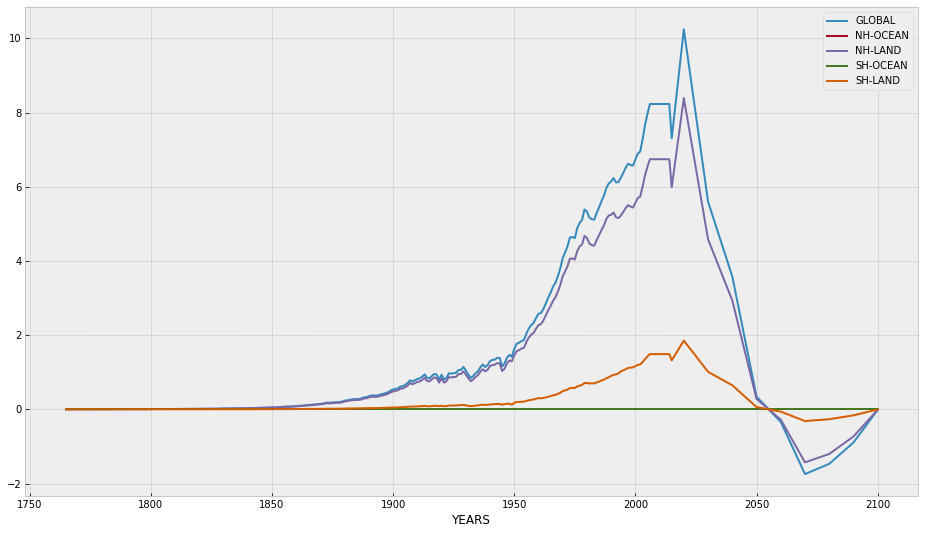

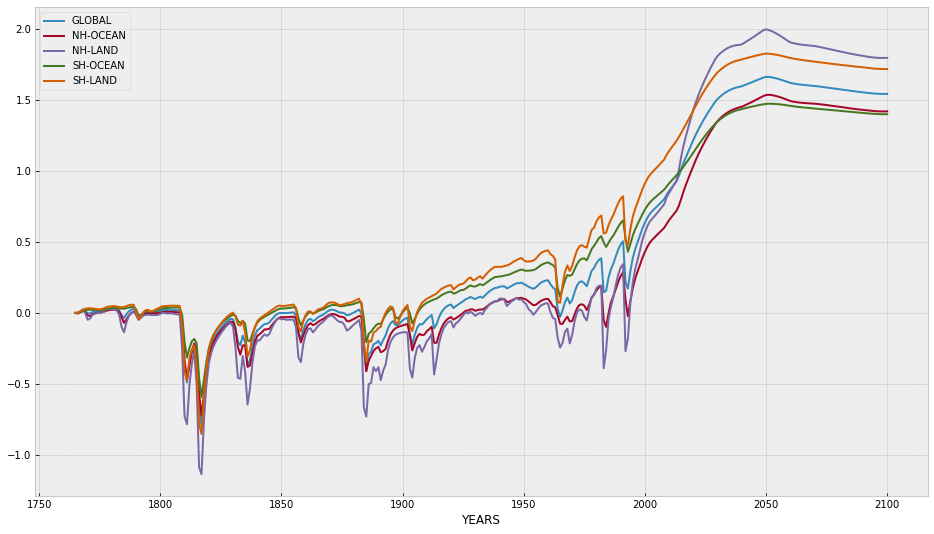

In [32]:
results = pymagicc.run(scenario)
results['CO2I_EMIS'].plot(figsize=(16, 9))
results['SURFACE_TEMP'].plot(figsize=(16, 9));